In [26]:
import scipy

In [27]:
from networkx.algorithms import bipartite
import networkx as nx
#random_graph(n, m, p[, seed, directed])
n = 20
m = 20
p = 0.6
seed = 1
directed = False
G = bipartite.random_graph(n, m, p, seed, directed)
reference_matching = nx.max_weight_matching(G, maxcardinality=True)
assert (len(reference_matching)==n)
import scipy.sparse as sps
# Convert the graph to a SciPy sparse matrix
mat = nx.to_scipy_sparse_array(G,format="lil")
#mat.setdiag(1)
print(mat.shape)

(40, 40)


In [28]:
from scipy.sparse import triu, tril
# Set diagonal to 1 so matrix is invertible
# Extract upper triangle of symmetric sparse matrix
upper_triangle = triu(mat,format="csc", k=1)
lower_triangle = tril(mat,format="csc")
mat=lower_triangle+(upper_triangle*-1)
print(mat.shape)

(40, 40)


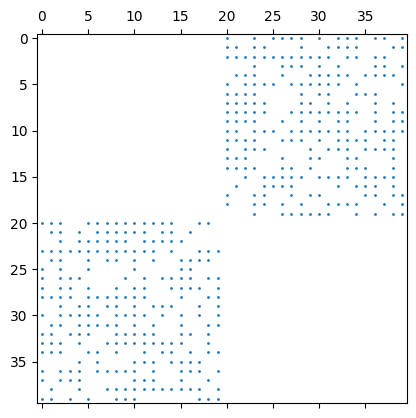

In [29]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.spy(mat, aspect='equal', marker='.', markersize=2)


In [30]:
import time
import numpy as np
start_time = time.time()
# Set the data array in place to random integers between 0 and nnz
mat.data = np.random.randint(1, mat.nnz + 1, size=mat.nnz)
# Record the stop time
stop_time = time.time()
# Calculate the elapsed time
elapsed_time = stop_time - start_time
print(f"Randomized Adj in {elapsed_time} seconds")
start_time = time.time()
invMat = sps.linalg.inv(mat)
# Record the stop time
stop_time = time.time()
# Calculate the elapsed time
elapsed_time = stop_time - start_time
print(f"Inverted Matrix in {elapsed_time} seconds")
matBackup=mat.copy()
invMatBackup=invMat.copy()


Randomized Adj in 0.0001819133758544922 seconds
Inverted Matrix in 0.011191129684448242 seconds


In [31]:
from scipy import linalg
Aij = matBackup.copy().tocoo()
denseAdj = matBackup.copy().todense()
invMat = sps.linalg.inv(matBackup)
denseInv = invMat.copy().todense()
w = linalg.det(denseInv)
matchingGaussian = []
# Let A be an nxn matrix
# Denote by Aij the (n-1)x(n-1) submatrix obtained by removing the ith row and jth column
# Denote by Aii,jj the (n-2)x(n-2) submatrix obtained by removing the ith row and column
# and jth row and column
# Simply zeroing out rows/columns not in the submatrix won't work because
# 3.5.1 Matrices with rows or columns of zeroes are not invertible
# https://www.ucl.ac.uk/~ucahmto/0005_2021/Ch3.S5.html
rowlabels = [i for i in range(mat.shape[0] + 1)]
collabels = [i for i in range(mat.shape[1] + 1)]
# n/2 iterations
for r in range (mat.shape[0]//2):
    #print(r)
    # Simplify finding a column in the first row.
    for c in range (denseAdj.shape[1]):
        if (denseAdj[0,c]!=0.0 and denseInv[c,0]!=0.0):
            #print("Found edge", (rowlabels[0],collabels[c]))
            newAdj = denseAdj.copy()
            matchingGaussian.append((rowlabels[0],collabels[c]))
            # Define a mask for rows and columns to exclude
            rows_to_exclude = [0,c]
            cols_to_exclude = [c,0]
            # Create a boolean mask for rows and columns to keep
            rows_to_keep = np.ones(newAdj.shape[0], dtype=bool)
            cols_to_keep = np.ones(newAdj.shape[1], dtype=bool)
            rows_to_keep[rows_to_exclude] = False
            cols_to_keep[cols_to_exclude] = False
            
            # Apply the mask to the matrix
            denseAdj = newAdj[rows_to_keep][:, cols_to_keep]
            if (denseAdj.shape[0]>0):
                denseInv = scipy.linalg.inv(denseAdj)
                #print(denseAdj.shape)
                rowlabels.pop(c)
                rowlabels = rowlabels[1:]  # This creates a new list without the first element
                collabels.pop(c)
                collabels = collabels[1:]  # This creates a new list without the first element
                break

assert(len(reference_matching)==len(matchingGaussian))

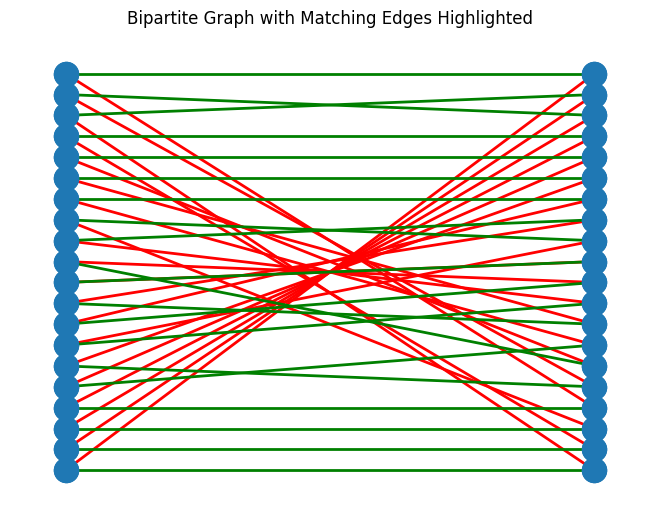

In [32]:
# Draw the graph with the perfect matching edges highlighted
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Get the nodes in each partition
partition1_nodes, partition2_nodes = bipartite.sets(G)
# Use bipartite_layout for bipartite graph visualization
pos = nx.bipartite_layout(G, partition1_nodes)

matching_graph = nx.Graph()
matching_graph.add_edges_from(reference_matching)

# Create a new graph with only the matching edges
#matching_gaussian_edges = [(u, v) for u, v in G.edges() if (u, v) in matching or (v, u) in matching]
matching_gaussian_edges = nx.Graph()
matching_gaussian_edges.add_edges_from(matchingGaussian)

# Draw the bipartite graph with matching edges highlighted in red
#nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=edge_colors, width=2.0)
nx.draw(matching_graph, pos, with_labels=False, edge_color='r', width=2.0)
nx.draw(matching_gaussian_edges, pos, with_labels=False, edge_color='g', width=2.0)

plt.title("Bipartite Graph with Matching Edges Highlighted")
plt.show()


In [33]:
import scipy.sparse as sps
from scipy.sparse import triu, tril
from scipy import linalg
def GaussMatching(G):
    # Convert the graph to a SciPy sparse matrix
    mat = nx.to_scipy_sparse_array(G,format="lil")
    #mat.setdiag(1)
    # Set diagonal to 1 so matrix is invertible
    # Extract upper triangle of symmetric sparse matrix
    upper_triangle = triu(mat,format="csc", k=1)
    lower_triangle = tril(mat,format="csc")
    mat=lower_triangle+(upper_triangle*-1)
    mat.data = np.random.randint(1, mat.nnz + 1, size=mat.nnz)

    Aij = mat.copy().tocoo()
    denseAdj = mat.copy().todense()
    invMat = sps.linalg.inv(mat)
    denseInv = invMat.copy().todense()
    w = linalg.det(denseInv)
    matchingGaussian = []
    # Let A be an nxn matrix
    # Denote by Aij the (n-1)x(n-1) submatrix obtained by removing the ith row and jth column
    # Denote by Aii,jj the (n-2)x(n-2) submatrix obtained by removing the ith row and column
    # and jth row and column
    # Simply zeroing out rows/columns not in the submatrix won't work because
    # 3.5.1 Matrices with rows or columns of zeroes are not invertible
    # https://www.ucl.ac.uk/~ucahmto/0005_2021/Ch3.S5.html
    rowlabels = [i for i in range(mat.shape[0] + 1)]
    collabels = [i for i in range(mat.shape[1] + 1)]
    # n/2 iterations
    for r in range (mat.shape[0]//2):
        #print(r)
        # Simplify finding a column in the first row.
        for c in range (denseAdj.shape[1]):
            if (denseAdj[0,c]!=0.0 and denseInv[c,0]!=0.0):
                #print("Found edge", (rowlabels[0],collabels[c]))
                newAdj = denseAdj.copy()
                matchingGaussian.append((rowlabels[0],collabels[c]))
                # Define a mask for rows and columns to exclude
                rows_to_exclude = [0,c]
                cols_to_exclude = [c,0]
                # Create a boolean mask for rows and columns to keep
                rows_to_keep = np.ones(newAdj.shape[0], dtype=bool)
                cols_to_keep = np.ones(newAdj.shape[1], dtype=bool)
                rows_to_keep[rows_to_exclude] = False
                cols_to_keep[cols_to_exclude] = False

                # Apply the mask to the matrix
                denseAdj = newAdj[rows_to_keep][:, cols_to_keep]
                if (denseAdj.shape[0]>0):
                    denseInv = scipy.linalg.inv(denseAdj)
                    #print(denseAdj.shape)
                    rowlabels.pop(c)
                    rowlabels = rowlabels[1:]  # This creates a new list without the first element
                    collabels.pop(c)
                    collabels = collabels[1:]  # This creates a new list without the first element
                    break
    return(matchingGaussian)

In [45]:
import scipy.sparse as sps
from scipy.sparse import triu, tril
from scipy import linalg
from scipy.sparse.csgraph import structural_rank
from sympy import nextprime
def GaussMatchingCardinality(G):
    # Convert the graph to a SciPy sparse matrix
    mat = nx.to_scipy_sparse_array(G,format="lil")
    #mat.setdiag(1)
    # Set diagonal to 1 so matrix is invertible
    # Extract upper triangle of symmetric sparse matrix
    upper_triangle = triu(mat,format="csc", k=1)
    lower_triangle = tril(mat,format="csc")
    mat=lower_triangle+(upper_triangle*-1)
    n = mat.shape[0]
    next_prime = nextprime(n**4)
    mat.data = np.random.randint(1, next_prime, size=mat.nnz)
    
    try:
        invMat = sps.linalg.inv(mat)
        lu = scipy.sparse.linalg.splu(invMat)
        diagL = lu.L.diagonal()
        diagU = lu.U.diagonal()
        L,U = lu.L, lu.U
        d = diagL.prod()*diagU.prod()
        #print("sparse det",d)
        invertible=True
    except Exception:
        invertible=False
        d = 0.0

    if (d !=- 0.0 ):
        r = structural_rank(mat)
        return(r//2)
    else:
        raise CustomError("Perfect matching doesn't exist.")

ModuleNotFoundError: No module named 'sympy'

In [44]:
verticesInMatching = GaussMatchingCardinality(G)
print(verticesInMatching)

20


In [9]:
# Draw the graph with the perfect matching edges highlighted
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
def PlotMatching(G,Edmonds,Gauss):
    # Get the nodes in each partition
    partition1_nodes, partition2_nodes = bipartite.sets(G)
    # Use bipartite_layout for bipartite graph visualization
    pos = nx.bipartite_layout(G, partition1_nodes)

    matching_graph = nx.Graph()
    matching_graph.add_edges_from(Edmonds)

    # Create a new graph with only the matching edges
    #matching_gaussian_edges = [(u, v) for u, v in G.edges() if (u, v) in matching or (v, u) in matching]
    matching_gaussian_edges = nx.Graph()
    matching_gaussian_edges.add_edges_from(Gauss)

    # Draw the bipartite graph with matching edges highlighted in red
    #nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=edge_colors, width=2.0)
    # Draw the isolated nodes as well
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes)

    nx.draw(matching_graph, pos, with_labels=True, edge_color='r', width=2.0)

    plt.title("Bipartite Graph with Edmonds Edges Highlighted")
    plt.show()
    plt.title("Bipartite Graph with Gauss Edges Highlighted")
    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes)
    nx.draw(matching_gaussian_edges, pos, with_labels=True, edge_color='g', width=2.0)
    plt.show()


In [10]:
def has_duplicate_values(pairs):
    seen_values = set()
    
    for pair in pairs:
        for value in pair:
            if value in seen_values:
                return True
            seen_values.add(value)
    
    return False

Generated Bipartite Graph in 0.0002262592315673828 seconds
Generated reference matching in 0.0006341934204101562 seconds
Convert the graph to a SciPy sparse matrix in 0.0006306171417236328 seconds


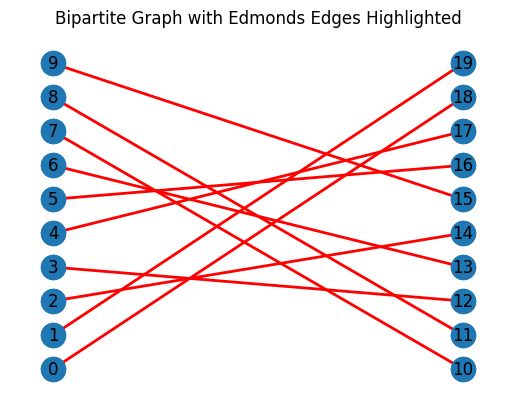

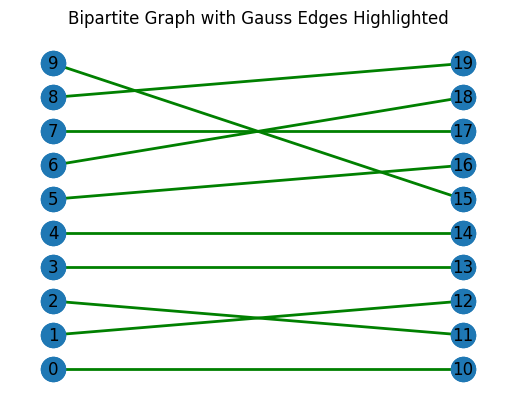

n=10, Average Gauss Execution Time: 0.006632528995396569 seconds
n=10, Valid Matching Gauss: True
n=10, Length Matching Gauss: 10
n=10, Average Edmonds Execution Time: 0.0005101980059407651 seconds
n=10, Valid Matching Edmonds: True
n=10, Length Matching Edmonds: 10
Generated Bipartite Graph in 0.008784055709838867 seconds
Generated reference matching in 0.03015279769897461 seconds
Convert the graph to a SciPy sparse matrix in 0.005316257476806641 seconds


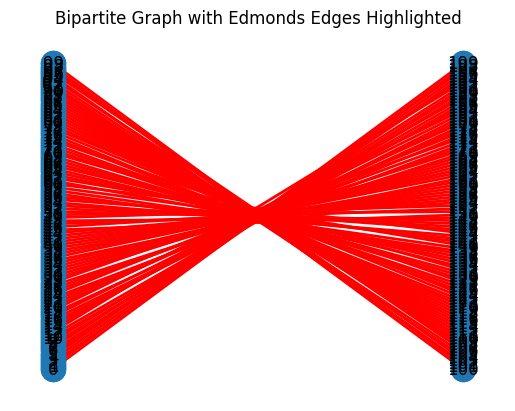

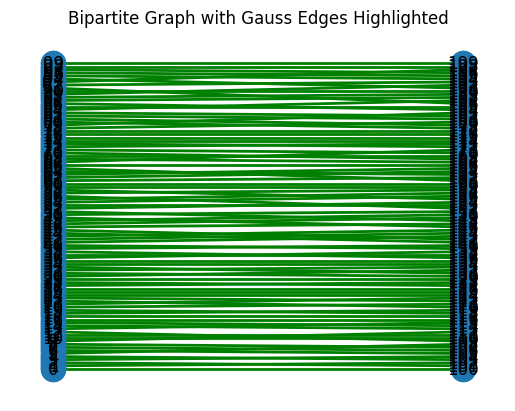

n=100, Average Gauss Execution Time: 1.705310190009186 seconds
n=100, Valid Matching Gauss: True
n=100, Length Matching Gauss: 100
n=100, Average Edmonds Execution Time: 0.04437724201125093 seconds
n=100, Valid Matching Edmonds: True
n=100, Length Matching Edmonds: 100
Generated Bipartite Graph in 0.8442425727844238 seconds
Generated reference matching in 2.622629165649414 seconds
Convert the graph to a SciPy sparse matrix in 1.8945236206054688 seconds


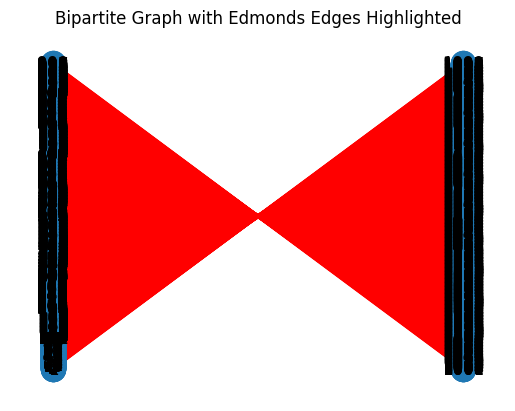

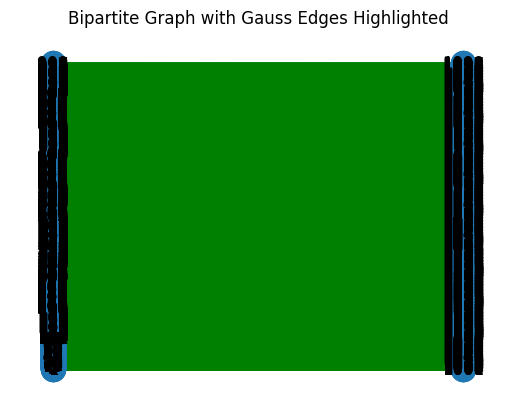

n=1000, Average Gauss Execution Time: 120.03747882800235 seconds
n=1000, Valid Matching Gauss: True
n=1000, Length Matching Gauss: 1000
n=1000, Average Edmonds Execution Time: 2.6286033260112163 seconds
n=1000, Valid Matching Edmonds: True
n=1000, Length Matching Edmonds: 1000


In [11]:
from networkx.algorithms import bipartite
import networkx as nx
import timeit
import time
# Wrap the code in a loop to increase n by powers of 10
for exponent in range(1, 4):  # Increase n by powers of 10 (1 to 4)
    n = 10 ** exponent
    m = n
    p = 0.6
    seed = 1
    directed = False
    
    # Generate a random graph
    # Record the start time
    start_time = time.time()
    G = nx.bipartite.random_graph(n, m, p, seed, directed)
    # Record the stop time
    stop_time = time.time()
    # Calculate the elapsed time
    elapsed_time = stop_time - start_time
    print(f"Generated Bipartite Graph in {elapsed_time} seconds")
    # Convert the graph to a SciPy sparse matrix
    start_time = time.time()
    
    start_time = time.time()
    Edmonds = nx.max_weight_matching(G, maxcardinality=True)
    # Record the stop time
    stop_time = time.time()
    # Calculate the elapsed time
    elapsed_time = stop_time - start_time
    print(f"Generated reference matching in {elapsed_time} seconds")
    start_time = time.time()
    assert (len(Edmonds)==n)

    mat = nx.to_scipy_sparse_array(G, format="csc")
    # Record the stop time
    stop_time = time.time()
    # Calculate the elapsed time
    elapsed_time = stop_time - start_time
    print(f"Convert the graph to a SciPy sparse matrix in {elapsed_time} seconds")
    # Wrap the gaussmatching method in a timeit function to get average time
    def time_Gauss():
        return GaussMatching(G)
    def time_Edmonds():
        return nx.max_weight_matching(G, maxcardinality=True)
    Gauss = GaussMatching(G)
    PlotMatching(G,Edmonds,Gauss)
    assert(len(Gauss)==len(Edmonds))
    assert(not has_duplicate_values(Edmonds))
    assert(not has_duplicate_values(Gauss))
    numSamples = 1
    execution_timeGauss = timeit.timeit(time_Gauss, number=numSamples) / numSamples  # 100 runs for averaging
    execution_timeEdmonds = timeit.timeit(time_Edmonds, number=numSamples) / numSamples  # 100 runs for averaging
    print(f"n={n}, Average Gauss Execution Time: {execution_timeGauss} seconds")
    print(f"n={n}, Valid Matching Gauss: {not has_duplicate_values(Gauss)}")
    print(f"n={n}, Length Matching Gauss: {len(Gauss)}")

    #print(f"n={n}, Average GaussDOK Execution Time: {execution_timeGaussDOK} seconds")
    print(f"n={n}, Average Edmonds Execution Time: {execution_timeEdmonds} seconds")
    print(f"n={n}, Valid Matching Edmonds: {not has_duplicate_values(Edmonds)}")
    print(f"n={n}, Length Matching Edmonds: {len(Edmonds)}")
